The generator will load a batch of training samples each time. And for each single training sample, 3 images are all used from 3 cameras and 6 training samples are created after flipping left-right.

In [1]:
import csv
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def loadImageFromSingleTimeFrame(line, dataDir):
    xs = []
    ys = []
    
    correction = 0.22
    
    for view in range(3):
        origPath = line[view]
        filename = origPath.split('/')[-1]
        newPath = dataDir + filename
        
        x = cv2.imread(newPath)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        steer = float(line[3])
                       
        if view == 1: # Left view
            steer += correction
        if view == 2: # Right view
            steer -= correction
        
        xs.append(np.array(x))
        ys.append(steer)
        
    
    return xs,ys

def generator(samples, batch_size=32, dataDir='data/IMG/'):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for line_sample in batch_samples:
                xs, ys = loadImageFromSingleTimeFrame(line_sample, dataDir)
                for i in range(len(xs)):
                    x = xs[i]
                    y = ys[i]
                    images.append(x)
                    angles.append(y)
                    images.append(cv2.flip(x, 1))
                    angles.append(-1*y)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)


Build the neural network model structure. Two versions of networks are tried out, the AlexNet and the NvidiaNet.

In [2]:
# useAlexNet = True
useAlexNet = False

In [3]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Lambda, Convolution2D,MaxPooling2D, Dropout, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf

top_crop, bottom_crop = 60, 20
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
model.add(Lambda(lambda x:x/127.5 - 1.0, input_shape=(row,col,ch)))
# trim image to only see section with road
model.add(Cropping2D(cropping=((top_crop,bottom_crop), (0,0)), dim_ordering='tf'))
# model.add(Lambda(lambda image: tf.image.resize_images(image, (64, 64))))
    
def AlexNet(model):
    model.add(Convolution2D(6,5,5,activation="relu"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6,5,5,activation="relu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dropout(0.2))
    model.add(Dense(84))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def NvidiaNet(model):
    model.add(Convolution2D(24,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(36,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(48,5,5, subsample=(2,2),activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

if useAlexNet:
    model = AlexNet(model)
else:
    model = NvidiaNet(model)
    
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [4]:
# load training file list
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
from sklearn.model_selection import train_test_split
train_lines, validation_lines = train_test_split(lines, test_size=0.2)

print('Training size: ', len(train_lines))
print('Validation size: ', len(validation_lines))

batchSize = 128
# compile and train the model using the generator function
train_generator = generator(train_lines, batch_size=batchSize)
validation_generator = generator(validation_lines, batch_size=batchSize)


Training size:  13497
Validation size:  3375


Visualize the distribution of training angles. Hopefully it's balanced between turning left and right (positive, negative).

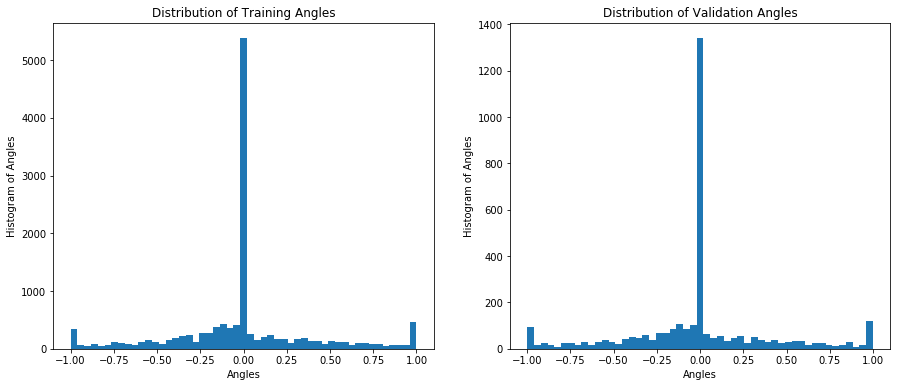

In [5]:
def allAngles(lines):
    angles = []
    for l in lines:
        angles.append(float(l[3]))
    return angles

train_angles = np.array(allAngles(train_lines))
valid_angles = np.array(allAngles(validation_lines))

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15,6)

plt.subplot(1,2, 1)
plt.hist(train_angles, bins=51)
plt.title('Distribution of Training Angles')
plt.ylabel('Histogram of Angles')
plt.xlabel('Angles')

plt.subplot(1,2, 2)
plt.hist(valid_angles, bins=51)
plt.title('Distribution of Validation Angles')
plt.ylabel('Histogram of Angles')
plt.xlabel('Angles')

plt.show()

In [6]:

adam = Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam)

# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=10, batch_size=256, verbose=1)

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_lines), \
                                     validation_data=validation_generator, \
                                     nb_val_samples=len(validation_lines), \
                                     nb_epoch= 20, \
                                     verbose = 1)

if useAlexNet:
    model.save('model/model_center_andLeftRight_cropped_TwoTracks_AlexNet.h5')
else:
    model.save('model/model_center_andLeftRight_cropped_TwoTracks_NvidiaNet.h5')


Epoch 1/20
13056/13497 [============================>.] - ETA: 1s - loss: 0.1537

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


13824/13497 [==============================] - 47s - loss: 0.1537 - val_loss: 0.1334
Epoch 2/20
13824/13497 [==============================] - 39s - loss: 0.1328 - val_loss: 0.1060
Epoch 3/20
13824/13497 [==============================] - 39s - loss: 0.1130 - val_loss: 0.1009
Epoch 4/20
13824/13497 [==============================] - 39s - loss: 0.1137 - val_loss: 0.0948
Epoch 5/20
13824/13497 [==============================] - 39s - loss: 0.1056 - val_loss: 0.0939
Epoch 6/20
14166/13497 [===============================] - 42s - loss: 0.0989 - val_loss: 0.0887
Epoch 7/20
13824/13497 [==============================] - 39s - loss: 0.0924 - val_loss: 0.0919
Epoch 8/20
13824/13497 [==============================] - 39s - loss: 0.0964 - val_loss: 0.0919
Epoch 9/20
13824/13497 [==============================] - 39s - loss: 0.0916 - val_loss: 0.0887
Epoch 10/20
13824/13497 [==============================] - 39s - loss: 0.0955 - val_loss: 0.0866
Epoch 11/20
13824/13497 [========================

In [7]:
import json

json_string = model.to_json()
filename_jsonModel = 'model_center_andLeftRight_cropped_TwoTracks_NvidiaNet.json'
with open(filename_jsonModel, 'w') as jfile:
    json.dump(json_string, jfile)

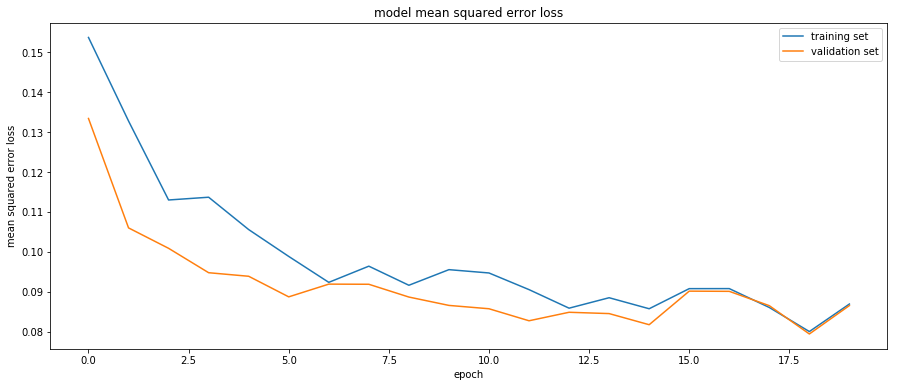

In [8]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

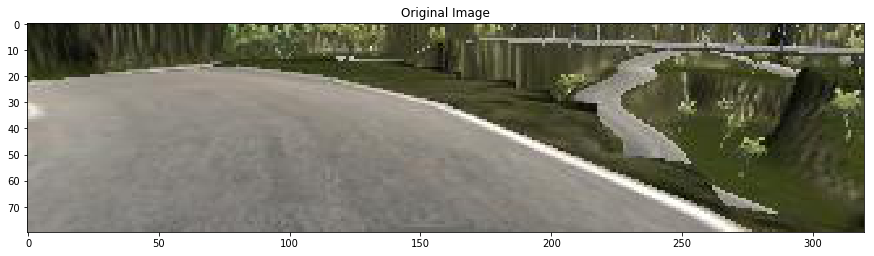

In [9]:
from keras import backend as K

xs, yx = loadImageFromSingleTimeFrame(train_lines[55], dataDir='data/IMG/')
x_center = xs[0] # center image

plt.imshow(x_center[60:140,:])
plt.title('Original Image')
plt.show()

Check the weights of the first and second conv layers

In [10]:
model.summary()

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

func_conv1 = functors[2]
func_conv2 = functors[3]
layer_outs = func_conv1([x_center[np.newaxis], 1.])
layer_outs2 = func_conv2([x_center[np.newaxis], 1.])
w_conv1 = np.squeeze(layer_outs[0])
w_conv2 = np.squeeze(layer_outs2[0])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

shape of conv1 layer:  (38, 158, 24)


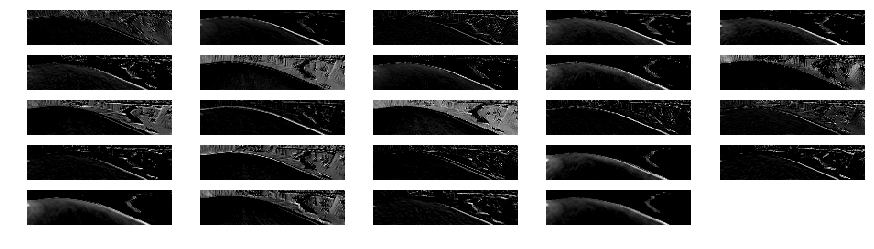

In [11]:
print('shape of conv1 layer: ', w_conv1.shape)
plt.rcParams['figure.figsize'] = (15, 4)

for i in range(w_conv1.shape[2]):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.squeeze(w_conv1[...,i]), cmap='gray')
    plt.axis('off')
    
plt.show()

shape of conv2 layer:  (17, 77, 36)


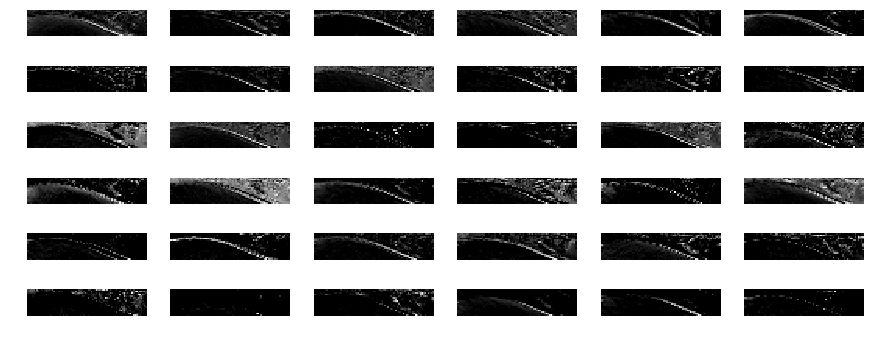

In [12]:
print('shape of conv2 layer: ', w_conv2.shape)
plt.rcParams['figure.figsize'] = (15, 6)

for i in range(w_conv2.shape[2]):
    plt.subplot(6, 6, i+1)
    plt.imshow(w_conv2[...,i], cmap='gray')
    plt.axis('off')
    
plt.show()

**Transfer Learning**

After first submission, the reviewer found that the car occasionally step over the red alert zone and suggest me to collect specific recovery data and update the model with these new data. 

As these new data are of the very similiar kind and it's a small amount, as suggested, the training will be done by freezing most of the layers other than the last one and re-train with the new data. 

In [16]:
from keras.models import load_model

modelFn = 'model/model_center_andLeftRight_cropped_TwoTracks_NvidiaNet.h5'
model = load_model(modelFn)

# Freeze all layers except for the last FC output layer
for layer in model.layers[:-1]:
    layer.trainable = False
    print(layer)
    
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [17]:
# Train again with the recover data collected
linesRecover = []
with open('recoveryData/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        linesRecover.append(line)
        
train_lines_rec, validation_lines_rec = train_test_split(linesRecover, test_size=0.2)
nTrain, nValid = len(train_lines_rec), len(validation_lines_rec)

print('Training size of recovery data: ', nTrain)
print('Validation size of recovery data: ', nValid)

batchSize = 64
# compile and train the model using the generator function
train_generator_rec = generator(train_lines_rec, batch_size=batchSize, dataDir='recoveryData/IMG/')
validation_generator_rec = generator(validation_lines_rec, batch_size=batchSize, dataDir='recoveryData/IMG/')

history_object = model.fit_generator(train_generator_rec, \
                                     samples_per_epoch=nTrain, \
                                     validation_data=validation_generator_rec, \
                                     nb_val_samples=nValid, \
                                     nb_epoch= 3, \
                                     verbose = 1)

# remove optimizer_weights, caused some trouble while loading model in local machine
model.compile(loss='mse', optimizer=adam)
    
if useAlexNet:
    model.save('model/model_AlexNet_Recover.h5')
else:
    model.save('model/model_NvidiaNet_Recover.h5')

Training size of recovery data:  1037
Validation size of recovery data:  260
Epoch 1/3
 768/1037 [=====================>........] - ETA: 0s - loss: 0.0617

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1152/1037 [=================================] - 4s - loss: 0.0560 - val_loss: 0.0575
Epoch 2/3
1152/1037 [=================================] - 3s - loss: 0.0561 - val_loss: 0.0536
Epoch 3/3
1152/1037 [=================================] - 3s - loss: 0.0438 - val_loss: 0.0565
